In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## the objective of this file is to analyze the imact of scientific films on the society
## from previous models it is sure that the model is getting overfit
df = pd.read_csv('./data/final_annotations.csv')

df.drop(["sentiments", "impacts", "film_title", "batch"], axis = 1, inplace = True)

In [3]:
df.head()

,sentence,sentiment,impact
0,Good restraint on the use of adjectives.,Positive,Engagement with Film
1,Enjoy seeing/tracking storms....fascinating...,Positive,Interest with Science Topic
2,"The sound design, visuals and narration are bl...",Positive,Engagement with Film
3,Richard Dormer had a calming voice that made t...,Positive,Engagement with Film
4,So many never seen before images and actual pi...,Positive,Engagement with Film


In [4]:
df.drop_duplicates(inplace = True)

In [6]:
## lets make a model for sentiment analysis first using XGBoost and weight balancing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from xgboost import XGBClassifier

X_1 = df.drop(["sentiment", "impact"], axis = 1)
y_1 = df["sentiment"]

In [7]:
y_1 = y_1.map({"Positive": 0, "Negative": 1, "Neutral": 2})

In [8]:
## using bag of words method to convert the text to vectors with stopwords removed and lemmitization
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

vectorizer = CountVectorizer(stop_words = stop_words, tokenizer = lemmatize_text)
X_1 = vectorizer.fit_transform(df["sentence"])

In [9]:
## saving the vectorizer for future use
import pickle
pickle.dump(vectorizer, open("./models/vectorizer.pkl", "wb"))

In [10]:

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_1),
                                        y = y_1                                                    
                                    )
class_weights = dict(zip(np.unique(y_1), class_weights))
class_weights

{0: 0.6312375249500998, 1: 1.1335125448028673, 2: 1.874074074074074}

In [11]:
## using SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X, y = smote.fit_resample(X_1, y_1)

In [12]:
## using stratify to make sure that the distribution of classes is same in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [13]:
## looking at bag of words dictionary
vectorizer.vocabulary_

{'good': 881,
 'restraint': 1674,
 'use': 2125,
 'adjective': 26,
 'enjoy': 649,
 'seeing': 1751,
 'tracking': 2053,
 'storm': 1907,
 'fascinating': 747,
 'sound': 1852,
 'design': 498,
 'visuals': 2160,
 'narration': 1317,
 'blended': 207,
 'well': 2188,
 'together': 2032,
 'richard': 1689,
 'dormer': 575,
 'calming': 272,
 'voice': 2161,
 'made': 1195,
 'film': 775,
 'enjoyable': 650,
 'watch': 2177,
 'many': 1212,
 'never': 1345,
 'seen': 1754,
 'image': 1000,
 'actual': 19,
 'picture': 1481,
 'taken': 1971,
 'probe': 1550,
 'enjoyed': 651,
 'video': 2150,
 'felt': 763,
 'would': 2233,
 'effective': 618,
 'shorter': 1790,
 'tell': 1987,
 'produced': 1554,
 'targeted': 1976,
 'high': 943,
 'school': 1734,
 'class': 324,
 'fine': 781,
 'also': 62,
 'need': 1336,
 'le': 1138,
 'simplified': 1805,
 'documentary': 568,
 'like': 1159,
 'one': 1398,
 'includes': 1022,
 'breathtaking': 242,
 'astonishingly': 120,
 'complex': 366,
 'visual': 2157,
 'simulation': 1808,
 'talk': 1973,
 'alot':

In [15]:
X_1.shape

(1265, 2257)

## XGBoost Classifier

In [16]:
model = XGBClassifier()

model.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [17]:
y_pred = model.predict(X_train)

print("Accuracy on train set: ", accuracy_score(y_train, y_pred))

Accuracy on train set:  0.8683718028696195


In [18]:
print("Classification Report on train set: ", classification_report(y_train, y_pred))

Classification Report on train set:                precision    recall  f1-score   support

           0       0.97      0.71      0.82       534
           1       0.92      0.90      0.91       534
           2       0.77      1.00      0.87       535

    accuracy                           0.87      1603
   macro avg       0.89      0.87      0.87      1603
weighted avg       0.89      0.87      0.87      1603



<AxesSubplot: >

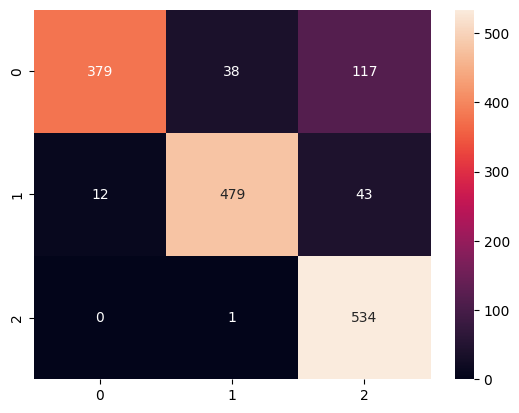

In [19]:
## plotting the confusion matrix

cm = confusion_matrix(y_train, y_pred)

sns.heatmap(cm, annot = True, fmt = "d")

In [20]:
y_pred = model.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))

Accuracy on test set:  0.7780548628428927


In [21]:
print("Classification Report on test set: ", classification_report(y_test, y_pred))

Classification Report on test set:                precision    recall  f1-score   support

           0       0.91      0.63      0.75       134
           1       0.81      0.75      0.78       134
           2       0.69      0.95      0.80       133

    accuracy                           0.78       401
   macro avg       0.80      0.78      0.78       401
weighted avg       0.80      0.78      0.78       401



## SVM

In [22]:
## svm model

from sklearn.svm import SVC

model = SVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_train)

In [23]:
print("Accuracy on train set: ", accuracy_score(y_train, y_pred))

Accuracy on train set:  0.8577666874610106


In [24]:
print("Classification Report on train set: ", classification_report(y_train, y_pred))

Classification Report on train set:                precision    recall  f1-score   support

           0       0.97      0.94      0.95       534
           1       0.98      0.64      0.78       534
           2       0.72      0.99      0.84       535

    accuracy                           0.86      1603
   macro avg       0.89      0.86      0.86      1603
weighted avg       0.89      0.86      0.86      1603



<AxesSubplot: >

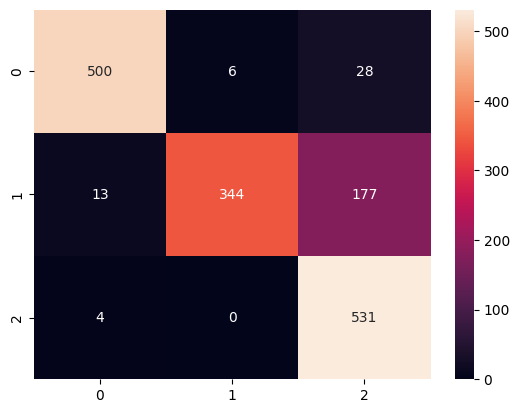

In [25]:
## plotting the confusion matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot = True, fmt = "d")

In [26]:
y_pred = model.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))

print("Classification Report on test set: \n", classification_report(y_test, y_pred))

Accuracy on test set:  0.6533665835411472
Classification Report on test set: 
               precision    recall  f1-score   support

           0       0.67      0.86      0.75       134
           1       0.77      0.28      0.41       134
           2       0.61      0.83      0.70       133

    accuracy                           0.65       401
   macro avg       0.68      0.65      0.62       401
weighted avg       0.68      0.65      0.62       401



<AxesSubplot: >

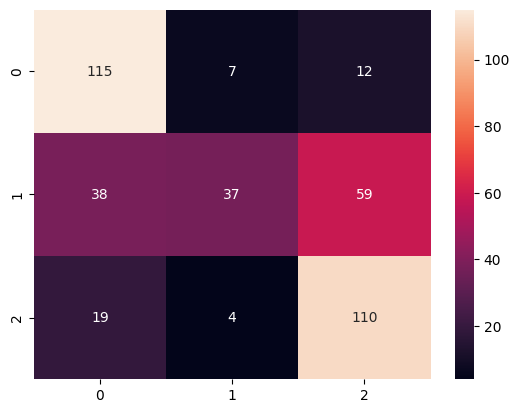

In [27]:
## plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "d")

In [28]:
df = df[df["impact"] != "TBD"]

df.dropna(inplace = True)

y = df["impact"]
X = df["sentence"]

y.value_counts()

Engagement with Film           768
Not applicable                 193
Shift in Knowledge             142
Interest with Science Topic     89
Impersonal Report               41
Name: impact, dtype: int64

In [29]:
X = vectorizer.transform(X)

In [30]:
y = y.map({"Engagement with Film": 0, "Not applicable": 1, "Shift in Knowledge": 2, "Interest with Science Topic":3, "Impersonal Report":4 })

In [31]:
y.value_counts()

0    768
1    193
2    142
3     89
4     41
Name: impact, dtype: int64

In [32]:
X, y = smote.fit_resample(X, y)

In [33]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y                                                    
                                    )
class_weights = dict(zip(np.unique(y), class_weights))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

model = XGBClassifier()

model.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [35]:
y_pred = model.predict(X_train)

print("Accuracy on train set: ", accuracy_score(y_train, y_pred))

Accuracy on train set:  0.9495442708333334


In [36]:

print("Classification Report on train set: \n", classification_report(y_train, y_pred))

Classification Report on train set: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       615
           1       0.85      0.98      0.91       615
           2       0.99      0.97      0.98       614
           3       0.99      0.96      0.98       614
           4       1.00      0.99      1.00       614

    accuracy                           0.95      3072
   macro avg       0.95      0.95      0.95      3072
weighted avg       0.95      0.95      0.95      3072



<AxesSubplot: >

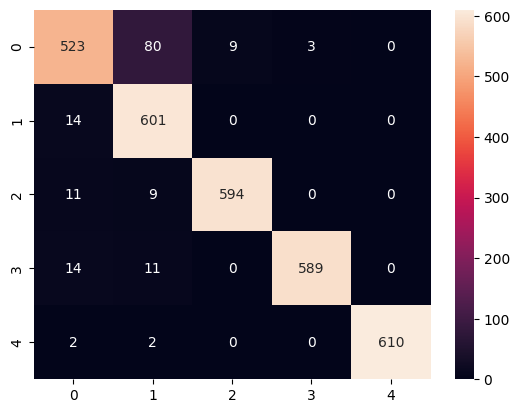

In [37]:
## plotting the confusion matrix
xm = confusion_matrix(y_train, y_pred)
sns.heatmap(xm, annot = True, fmt = "d")

In [38]:
y_pred = model.predict(X_test)

print("Accuracy on test set: ", accuracy_score(y_test, y_pred))

Accuracy on test set:  0.8828125


In [39]:
print("Classification Report on test set: \n", classification_report(y_test, y_pred))

Classification Report on test set: 
               precision    recall  f1-score   support

           0       0.77      0.75      0.75       153
           1       0.75      0.89      0.81       153
           2       0.96      0.86      0.91       154
           3       0.98      0.94      0.96       154
           4       0.99      0.98      0.98       154

    accuracy                           0.88       768
   macro avg       0.89      0.88      0.88       768
weighted avg       0.89      0.88      0.88       768



<AxesSubplot: >

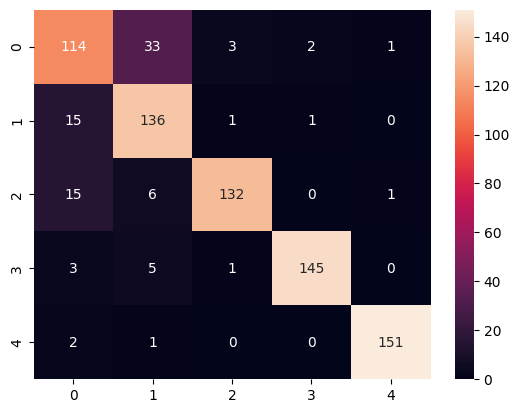

In [40]:
## plotting the confusion matrix
xm = confusion_matrix(y_test, y_pred)
sns.heatmap(xm, annot = True, fmt = "d")